# 🚀 S1W3D6: 推理实战

**今日目标**：学习如何使用已保存的模型进行预测。

## 1. 环境设置与导入

> 第一个单元格：挂载路径，导入我们之前封装好的`src`模块。

In [ ]:
import sys
import os

# 挂载项目根目录
project_root = os.path.abspath(os.path.join(os.getcwd(),"../.."))
if project_root not in sys.path:
    sys.path.append(project_root)

print(f"路径挂载成功：{project_root}")

路径挂载成功：/home/goodminton/study/AI-Interview-Sprint


## 2. 定义加载模型函数

> 第二个单元格：编写一个函数，专门负责把`.pth`文件加载进内存。

In [3]:
import torch
from src.models import SimpleCNN

def load_model(model_path, device):
    """
    加载训练好的模型权重
    """
    if not os.path.exists(model_path):
        raise FileExistsError(f"找不到模型文件：{model_path}")
    
    print(f"正在加载模型：{model_path}")

    # 1. 实例化模型（必须和训练时一模一样）
    model = SimpleCNN()

    # 2. 加载权重
    # map_location确保在CPU/GPU之间迁移不出错
    checkpoint = torch.load(model_path, map_location = device, weights_only = True)
    model.load_state_dict(checkpoint)

    # 3. 关键：切换到评估模式
    model.eval()

    # 4. 搬运到设备
    model.to(device)

    print(f"模型加载成功")
    
    return model

## 3. 定义预测函数（核心逻辑）

> 第三个单元格：处理单张图片，增加维度，进行预测。

In [4]:
def predict_single_image(model, image_tensor, device):
    """
    对单张图片进行预测
    :param image_tensor: [1, 28, 28]
    """
    # 1. 增加 Batch 维度: [1, 28, 28] -> [1, 1, 28, 28]
    input_tensor = image_tensor.unsqueeze(0).to(device)
    
    # 2. 阻断梯度
    with torch.no_grad():
        # 3. 推理
        output = model(input_tensor) # Logits
        
        # 4. 获取结果
        # output 是 [1, 10]，我们找最大值的索引
        pred_index = output.argmax(dim=1).item()
        
        # 5. (可选) 计算置信度
        probs = torch.nn.functional.softmax(output, dim=1)
        confidence = probs[0][pred_index].item() * 100
        
    return pred_index, confidence

## 4. 执行预测并可视化

> 第四个单元格：进行可视化预测

正在加载模型：/home/goodminton/study/AI-Interview-Sprint/experiments/best_model.pth
模型加载成功

🔍 正在预测第 1528 张图片...
🤖 预测结果: 1 (置信度: 100.00%)
🏷️ 真实标签: 1
✅ 正确


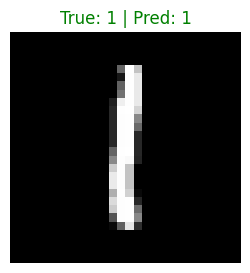

In [9]:
import random
import matplotlib.pyplot as plt
from src.utils import get_data_loaders

# --- 配置 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = os.path.join(project_root, 'experiments', 'best_model.pth')

# 1. 加载模型
model = load_model(model_path, device)

# 2. 获取测试数据（只用来取图）
_, test_loader = get_data_loaders(batch_size=1, data_root=os.path.join(project_root, 'data'))
dataset = test_loader.dataset

# 3. 随机抽一张图片
random_index = random.randint(0, len(dataset)-1)
image_tensor, true_label = dataset[random_index]

print(f"\n🔍 正在预测第 {random_index} 张图片...")

# 4. 预测
pred_label, conf = predict_single_image(model, image_tensor, device)

# 5. 结果显示
print(f"🤖 预测结果: {pred_label} (置信度: {conf:.2f}%)")
print(f"🏷️ 真实标签: {true_label}")

if pred_label == true_label:
    print("✅ 正确")
else:
    print("❌ 错误 (找到一个错题！)")

# 6. 画图
# 反归一化：为了让人眼看着舒服，把 -1~1 变回 0~1
img_vis = image_tensor.squeeze().numpy() * 0.3081 + 0.1307

plt.figure(figsize=(3, 3))
plt.imshow(img_vis, cmap='gray')
plt.title(f"True: {true_label} | Pred: {pred_label}", color=('green' if pred_label==true_label else 'red'))
plt.axis('off')
plt.show()